In [1]:
%load_ext autoreload
%autoreload 2
from rectangle import Rectangle
from environment import RectangleEnv
from optimizer import StepOptimizer
from algorithms import *

In [2]:
from sanity_tests import *

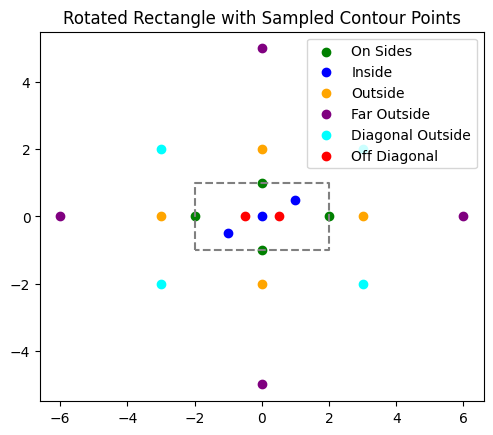

All tests passed!
Step 1: horizontal, shift=-1.999997934723917, used_iters=16
Step 2: vertical, shift=-0.5000000163044167, used_iters=10


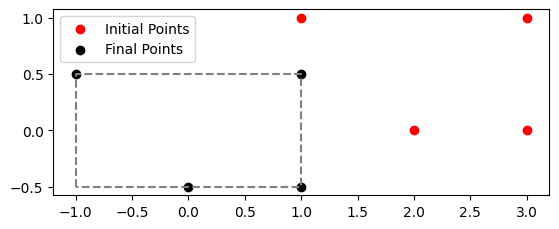


[check] encode_state invariants
Encoded state: (2, 0, 2, 0, 4, 0, 0)
 sides    (T,B,R,L):  2  0  2  0
 distances (touch,close,far):  4  0  0
  sum sides == N: True   sum bins == N: True

[check] axis isolation via apply_action()
  vertical: x unchanged? True | y changed? True
  horizontal: y unchanged? True | x changed? True

[run] short rollout using env.step()
 t        action  used   mean_before   mean_after    imprv     reward
------------------------------------------------------------------------
 0  ('horizontal', 2)     2      1.390388     0.447249   0.9431     0.0716
      expected≈ 0.7431  (set compute_reward(alpha=1,beta=0.1) to match)
      invariants: sides_sum==N? True | bins_sum==N? True
 1  ('vertical', 2)     2      0.447249     0.296303   0.1509    -0.3245
      expected≈ -0.0491  (set compute_reward(alpha=1,beta=0.1) to match)
      invariants: sides_sum==N? True | bins_sum==N? True
 2  ('horizontal', 4)     4      0.296303     0.233050   0.0633    99.2158
      exp

In [184]:
if __name__ == "__main__":
    # Run the sanity checks for the Rectangle class
    test_rectangle_distance()
    # Run the sanity checks for the RectangleEnv
    sanity_check_step_optimizer()

    env = build_env()
    env.render()

    # 1) state invariants on reset
    env.reset()
    check_encode_state_invariants(env)

    # 2) axis isolation (uses apply_action only)
    check_axis_isolation(env)

    # 3) rollout that prints distances, rewards, and invariants
    rollout_and_print(env, steps=18)

    # 4) terminal checks
    check_terminal_conditions(env)

    print("\n[done] If something looks off (e.g., reward != expected), tweak compute_reward or the alpha/beta used.")

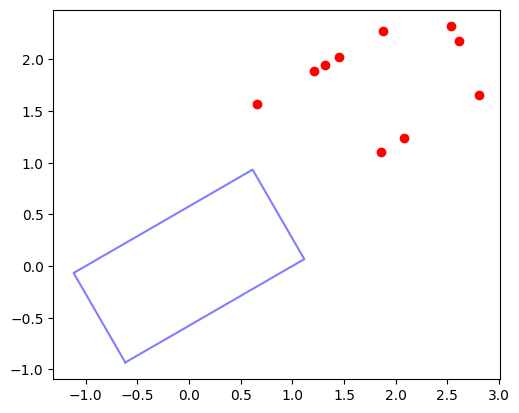

In [3]:
rect_params = dict(center=(0, 0), width=2.0, height=1.0, theta=np.pi/6)
optimizer_params = dict(tau=0.1, loss="soft_l1", bounds=(-5, 5))
offsetX, offsetY = np.random.uniform(-2, 3), np.random.uniform(-2, 3)
rect = Rectangle(**rect_params)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
rect.plot(ax=ax, color='blue', alpha=0.5)
rect.move(dx=offsetX, dy=offsetY)
points = rect.sample_points(num_points=10, jitter=0.0) 
ax.scatter(points[:, 0], points[:, 1], color='red', label='Sampled Points')
env = RectangleEnv(rect_params=rect_params, optimizer_params=optimizer_params, points=points)


In [4]:
import numpy as np

def make_cases(base_rect_params, optimizer_params, num_points=10, jitter=0.0):
    """
    Returns a dict[name] -> {
        'rect_params': dict,
        'optimizer_params': dict,
        'points': np.ndarray [num_points, 2],
        'offset': (dx, dy)
    }
    Points are sampled from a rectangle that is the base rectangle shifted by `offset`.
    The env you create later will try to realign these points to the *base* rectangle.
    """
    cases = {}

    def add(name, offset=(0.0, 0.0), theta=None, width=None, height=None):
        rect_params = dict(base_rect_params)
        if theta  is not None: rect_params['theta']  = theta
        if width  is not None: rect_params['width']  = width
        if height is not None: rect_params['height'] = height

        # build a temporary rectangle to generate the points
        R = Rectangle(**rect_params)
        R.move(dx=offset[0], dy=offset[1])
        pts = R.sample_points(num_points=num_points, jitter=jitter)

        cases[name] = {
            'rect_params': rect_params,
            'optimizer_params': dict(optimizer_params),
            'points': pts,
            'offset': tuple(offset),
        }

    # ---- fixed scenarios ----
    add("aligned",               offset=(0.0, 0.0))
    add("right_1p5",             offset=(1.5, 0.0))
    add("up_1p0",                offset=(0.0, 1.0))
    add("diag_2p0_1p5",          offset=(2.0, 1.5))
    add("left_down_-1p2_-0p8",     offset=(-1.2, -0.8), theta=np.pi/4)
    add("wide_offset_1p0_0p5",   offset=(1.0, 0.5), width=3.0)
    add("tall_offset_-0p5_1p2",  offset=(-0.5, 1.2), height=2.0)
    add("rot_-60_offset_8_-6", offset=(8, -6), theta=-np.pi/3)
    add("rot_30_offset_-4_3",  offset=(-4, 3), theta= np.pi/6)

    return cases

def build_envs_from_cases(cases):
    """Convenience: returns dict[name] -> RectangleEnv initialized with that case."""
    envs = {}
    for name, c in cases.items():
        envs[name] = RectangleEnv(
            rect_params=c['rect_params'],
            optimizer_params=c['optimizer_params'],
            points=c['points'],
        )
    return envs
rect_params = dict(center=(0, 0), width=2.0, height=1.0, theta=np.pi/6)
optimizer_params = dict(tau=0.1, loss="soft_l1", bounds=(-5, 5))

cases = make_cases(rect_params, optimizer_params, num_points=20, jitter=0.0)
envs  = build_envs_from_cases(cases)

# quick peek
for name, env in envs.items():
    s = env.reset()
    print(name, "points shape:", env.points.shape, "state:", s)


aligned points shape: (20, 2) state: (4, 7, 4, 5, 0, 0, 20)
right_1p5 points shape: (20, 2) state: (0, 8, 12, 0, 15, 4, 1)
up_1p0 points shape: (20, 2) state: (14, 0, 6, 0, 14, 5, 1)
diag_2p0_1p5 points shape: (20, 2) state: (6, 0, 14, 0, 20, 0, 0)
left_down_-1p2_-0p8 points shape: (20, 2) state: (5, 2, 0, 13, 13, 7, 0)
wide_offset_1p0_0p5 points shape: (20, 2) state: (4, 2, 14, 0, 12, 7, 1)
tall_offset_-0p5_1p2 points shape: (20, 2) state: (12, 0, 4, 4, 12, 8, 0)
rot_-60_offset_8_-6 points shape: (20, 2) state: (20, 0, 0, 0, 20, 0, 0)
rot_30_offset_-4_3 points shape: (20, 2) state: (4, 0, 0, 16, 20, 0, 0)


In [5]:
def run_algo(algo_name, example_name, env = RectangleEnv, episodes=500, **kwargs):
    """
    Convenience function to run an algorithm on the given environment.
    """
    if algo_name == 'sarsa':
        Q, logs = train_sarsa(env, episodes=episodes, **kwargs)
    elif algo_name == 'q_learning':
        Q, logs = train_q_learning(env, episodes=episodes, **kwargs)
    else:
        raise ValueError(f"Unknown algorithm: {algo_name}")
    metrics = run_episode(env, Q, render=True)
    display(env.log)
    print("greedy eval:", metrics)
    env.show_gif(filename=f"gifs/{example_name}_animation.gif")

In [7]:
params = {
    'episodes': 500,
    'alpha': 0.1,
    'gamma': 1,
    'eps_start': 0.2,
    'eps_end': 0.01,
    'eps_decay': 0.995,
    'seed': 0
}
env = envs['left_down_-1p2_-0p8']
run_algo('sarsa','left_down_-1p2_-0p8', env, **params)

["STEP 1 >>>>>> Action: ('vertical', 2), Used: 2, Delta: 0.8266197679834273, Old Dist: 0.7868",
 "STEP 2 >>>>>> Action: ('horizontal', 6), Used: 6, Delta: 1.1973370894878348, Old Dist: 0.6505",
 "STEP 3 >>>>>> Action: ('vertical', 2), Used: 2, Delta: -0.026224358517390564, Old Dist: 0.0186"]

greedy eval: {'return': np.float64(98.1818812044969), 'steps': 3, 'iters': 10, 'solved': True, 'final_mean_dist': 0.0018550024093668762}


In [8]:
env.log

["STEP 1 >>>>>> Action: ('vertical', 2), Used: 2, Delta: 0.8266197679834273, Old Dist: 0.7868",
 "STEP 2 >>>>>> Action: ('horizontal', 6), Used: 6, Delta: 1.1973370894878348, Old Dist: 0.6505",
 "STEP 3 >>>>>> Action: ('vertical', 2), Used: 2, Delta: -0.026224358517390564, Old Dist: 0.0186"]

In [9]:
for name, env in envs.items():
    print(f"-----------------{name}------------------")
    run_algo("sarsa", name, env, **params)
    print(f"-----------------------------------------\n")

-----------------aligned------------------


["STEP 1 >>>>>> Action: ('horizontal', 6), Used: 1, Delta: 0.0, Old Dist: 0.0000"]

greedy eval: {'return': np.float64(99.8), 'steps': 1, 'iters': 1, 'solved': True, 'final_mean_dist': 5.420451448736301e-17}
-----------------------------------------

-----------------right_1p5------------------


["STEP 1 >>>>>> Action: ('horizontal', 4), Used: 4, Delta: -1.499018523854435, Old Dist: 0.8201",
 "STEP 2 >>>>>> Action: ('horizontal', 2), Used: 2, Delta: -0.000981284131312044, Old Dist: 0.0007"]

greedy eval: {'return': np.float64(99.0051938533235), 'steps': 2, 'iters': 6, 'solved': True, 'final_mean_dist': 1.3466227844922426e-07}
-----------------------------------------

-----------------up_1p0------------------


["STEP 1 >>>>>> Action: ('vertical', 4), Used: 4, Delta: -0.9985419554194597, Old Dist: 0.5656",
 "STEP 2 >>>>>> Action: ('vertical', 6), Used: 3, Delta: -0.0014580445805042798, Old Dist: 0.0010"]

greedy eval: {'return': np.float64(98.7414869188499), 'steps': 2, 'iters': 7, 'solved': True, 'final_mean_dist': 2.4598889009082637e-14}
-----------------------------------------

-----------------diag_2p0_1p5------------------


["STEP 1 >>>>>> Action: ('horizontal', 2), Used: 2, Delta: -1.8336244517196134, Old Dist: 1.5100",
 "STEP 2 >>>>>> Action: ('vertical', 6), Used: 6, Delta: -1.553244448346233, Old Dist: 0.8983",
 "STEP 3 >>>>>> Action: ('horizontal', 6), Used: 6, Delta: -0.15140033866459884, Old Dist: 0.1135",
 "STEP 4 >>>>>> Action: ('horizontal', 4), Used: 2, Delta: -3.6172691279604884e-07, Old Dist: 0.0258"]

greedy eval: {'return': np.float64(97.25129537550819), 'steps': 4, 'iters': 16, 'solved': True, 'final_mean_dist': 0.025798290187954154}
-----------------------------------------

-----------------left_down_-1p2_-0p8------------------


["STEP 1 >>>>>> Action: ('vertical', 2), Used: 2, Delta: 0.8266197679834273, Old Dist: 0.7868",
 "STEP 2 >>>>>> Action: ('horizontal', 6), Used: 6, Delta: 1.1973370894878348, Old Dist: 0.6505",
 "STEP 3 >>>>>> Action: ('vertical', 2), Used: 2, Delta: -0.026224358517390564, Old Dist: 0.0186"]

greedy eval: {'return': np.float64(98.1818812044969), 'steps': 3, 'iters': 10, 'solved': True, 'final_mean_dist': 0.0018550024093668762}
-----------------------------------------

-----------------wide_offset_1p0_0p5------------------


["STEP 1 >>>>>> Action: ('horizontal', 6), Used: 6, Delta: -1.0459682657716358, Old Dist: 0.6580",
 "STEP 2 >>>>>> Action: ('vertical', 6), Used: 5, Delta: -0.4859475061720187, Old Dist: 0.2836",
 "STEP 3 >>>>>> Action: ('vertical', 6), Used: 1, Delta: 0.0, Old Dist: 0.0336"]

greedy eval: {'return': np.float64(97.71239006853237), 'steps': 3, 'iters': 12, 'solved': True, 'final_mean_dist': 0.03361311769248524}
-----------------------------------------

-----------------tall_offset_-0p5_1p2------------------


["STEP 1 >>>>>> Action: ('horizontal', 2), Used: 2, Delta: 0.13232643720706266, Old Dist: 0.6638",
 "STEP 2 >>>>>> Action: ('vertical', 6), Used: 6, Delta: -1.2290764088125035, Old Dist: 0.6941",
 "STEP 3 >>>>>> Action: ('horizontal', 6), Used: 6, Delta: 0.37145650567892685, Old Dist: 0.2417",
 "STEP 4 >>>>>> Action: ('vertical', 2), Used: 2, Delta: 0.025150450233636212, Old Dist: 0.0173"]

greedy eval: {'return': np.float64(96.90484397206166), 'steps': 4, 'iters': 16, 'solved': True, 'final_mean_dist': 0.0029044677331390603}
-----------------------------------------

-----------------rot_-60_offset_8_-6------------------


["STEP 1 >>>>>> Action: ('horizontal', 2), Used: 2, Delta: -2.23606797749979, Old Dist: 8.9958",
 "STEP 2 >>>>>> Action: ('horizontal', 2), Used: 2, Delta: -2.23606797749979, Old Dist: 7.3521",
 "STEP 3 >>>>>> Action: ('vertical', 4), Used: 4, Delta: 4.999856426155341, Old Dist: 6.0686",
 "STEP 4 >>>>>> Action: ('horizontal', 2), Used: 2, Delta: -2.23606797749979, Old Dist: 2.7708",
 "STEP 5 >>>>>> Action: ('horizontal', 4), Used: 4, Delta: -1.1252374922863702, Old Dist: 0.8841",
 "STEP 6 >>>>>> Action: ('vertical', 4), Used: 4, Delta: 0.9656928851308325, Old Dist: 0.5228",
 "STEP 7 >>>>>> Action: ('horizontal', 2), Used: 2, Delta: -0.1380704522023483, Old Dist: 0.1068",
 "STEP 8 >>>>>> Action: ('horizontal', 4), Used: 4, Delta: -0.02564159329056025, Old Dist: 0.0239"]

greedy eval: {'return': np.float64(98.66761227621899), 'steps': 8, 'iters': 24, 'solved': True, 'final_mean_dist': 0.022184393927201104}
-----------------------------------------

-----------------rot_30_offset_-4_3------------------


["STEP 1 >>>>>> Action: ('vertical', 2), Used: 2, Delta: -2.23606797749979, Old Dist: 4.0975",
 "STEP 2 >>>>>> Action: ('horizontal', 2), Used: 2, Delta: 2.23606797749979, Old Dist: 2.8997",
 "STEP 3 >>>>>> Action: ('horizontal', 2), Used: 2, Delta: 1.9647277917808326, Old Dist: 1.0532",
 "STEP 4 >>>>>> Action: ('horizontal', 2), Used: 2, Delta: -0.09884146691507839, Old Dist: 0.3287",
 "STEP 5 >>>>>> Action: ('vertical', 6), Used: 6, Delta: -0.7616861156523482, Old Dist: 0.3314",
 "STEP 6 >>>>>> Action: ('horizontal', 2), Used: 2, Delta: -0.09057701042239288, Old Dist: 0.0642"]

greedy eval: {'return': np.float64(98.75602855382222), 'steps': 6, 'iters': 16, 'solved': True, 'final_mean_dist': 0.007359805429882908}
-----------------------------------------



last 5 episode returns: [np.float64(1.0683580748285713), np.float64(1.0683580748285713), np.float64(1.0683580748285713), np.float64(1.0683580748285713), np.float64(1.0683580748285713)]
last 5 iters used:     [10, 10, 10, 10, 10]
success ratio: 50 / last 50


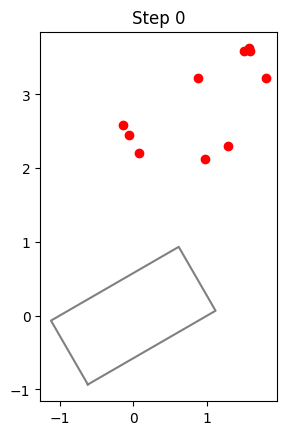

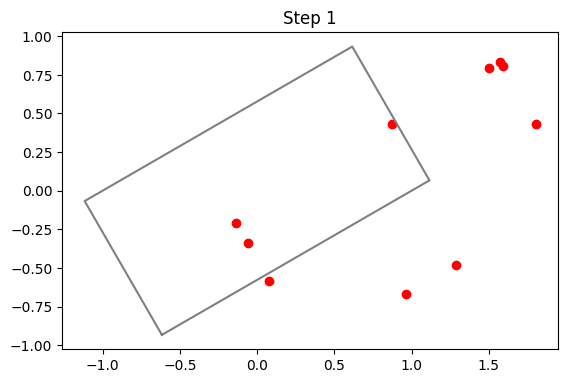

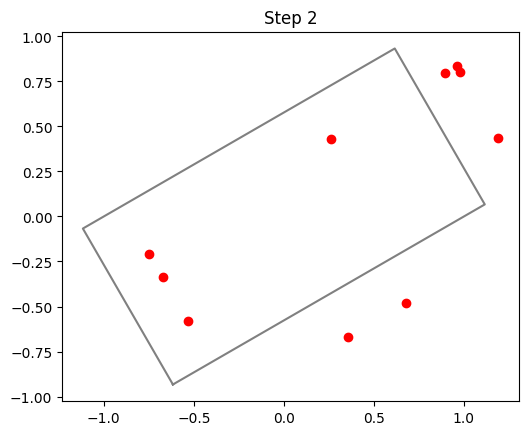

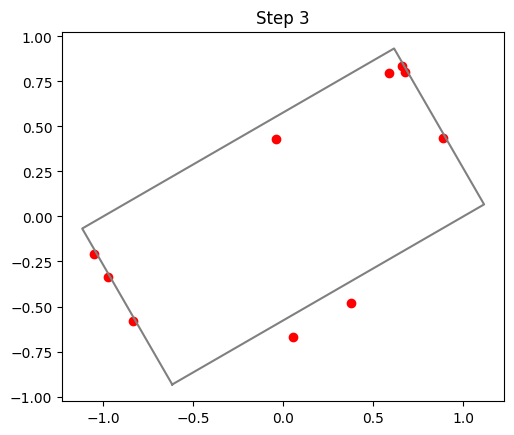

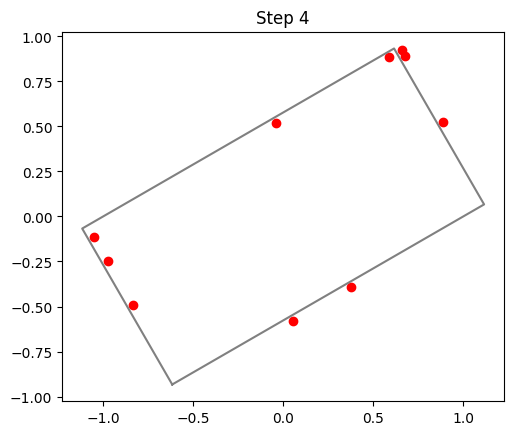

greedy eval: {'return': np.float64(1.0683580748285713), 'steps': 4, 'iters': 10, 'solved': True, 'final_mean_dist': 0.03056943577211113}


In [43]:
# from algorithms import train_sarsa, train_q_learning, run_episode
# # Train SARSA
Q, logs = train_sarsa(env, episodes=500, alpha=0.1, gamma=1,
                      eps_start=0.2, eps_end=0.01, eps_decay=0.995, seed=0)
# Q, logs = train_q_learning(env, episodes=400, alpha=0.1, gamma=1,
#                       eps_start=0.2, eps_end=0.01, eps_decay=0.995, seed=0)

# Inspect a few metrics
print("last 5 episode returns:", [d['return'] for d in logs[-5:]])
print("last 5 iters used:    ", [d['iters']  for d in logs[-5:]])
print("success ratio:", sum(d['solved'] for d in logs[-50:]), "/ last 50")

# Evaluate/render one greedy episode and get the total optimizer iterations used
metrics = run_episode(env, Q, render=True)
print("greedy eval:", metrics)

last 5 episode returns: [np.float64(1.0724246544024794), np.float64(0.4218585593220899), np.float64(1.2712410337673044), np.float64(1.085697355731375), np.float64(0.4351219459861)]
last 5 iters used:     [10, 16, 8, 10, 16]
success ratio: 50 / last 50


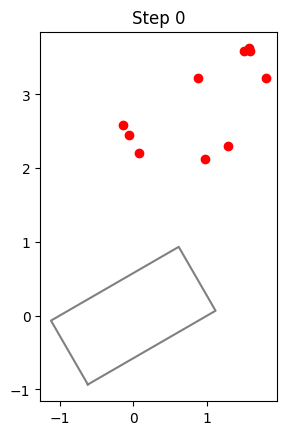

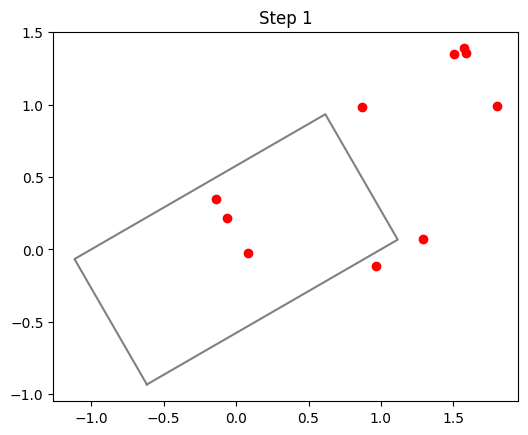

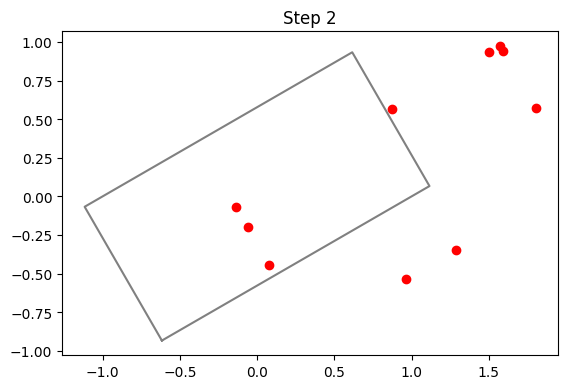

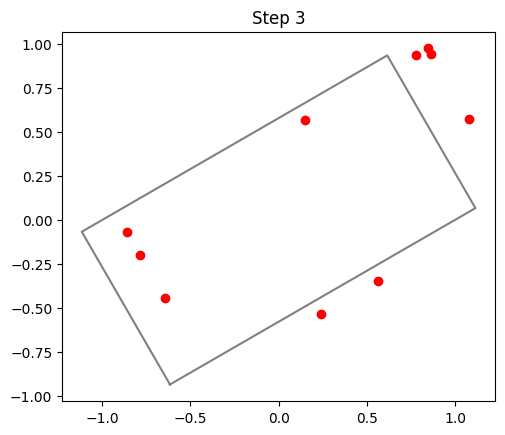

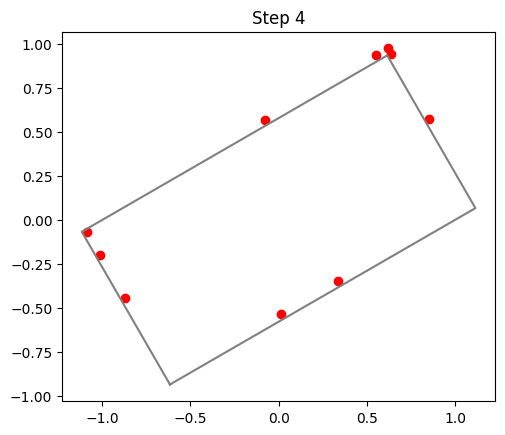

greedy eval: {'return': np.float64(1.2712410337673044), 'steps': 4, 'iters': 8, 'solved': True, 'final_mean_dist': 0.02768647683337804}


In [44]:
Q, logs = train_q_learning(env, episodes=500, alpha=0.1, gamma=0.99,
                      eps_start=0.4, eps_end=0.05, eps_decay=0.999, seed=0)

# Inspect a few metrics
print("last 5 episode returns:", [d['return'] for d in logs[-5:]])
print("last 5 iters used:    ", [d['iters']  for d in logs[-5:]])
print("success ratio:", sum(d['solved'] for d in logs[-50:]), "/ last 50")

# Evaluate/render one greedy episode and get the total optimizer iterations used
metrics = run_episode(env, Q, render=True)
print("greedy eval:", metrics)